# Medical School issues Medical Qualification to Doctor

## Before running through this notebook you have configured the agent in [Part 2.1 - Initialising the Medical School Agent.ipynb](http://127.0.0.1:8889/notebooks/Part%202.1%20-%20Initialising%20the%20Medical%20School%20Agent.ipynb).



## 1. Initialise a controller for Medical School

In [1]:
%autoawait
import time
import asyncio
from termcolor import colored,cprint

from aries_basic_controller.aries_controller import AriesAgentController
    
WEBHOOK_HOST = "0.0.0.0"
WEBHOOK_PORT = 8022
WEBHOOK_BASE = ""
ADMIN_URL = "http://medical-school-agent:8021"

# Based on the aca-py agent you wish to control
agent_controller = AriesAgentController(webhook_host=WEBHOOK_HOST, webhook_port=WEBHOOK_PORT,
                                       webhook_base=WEBHOOK_BASE, admin_url=ADMIN_URL)
    

IPython autoawait is `on`, and set to use `asyncio`


## 2. Register Listeners

The handler should get called every time the controller receives a webhook with the topic issue_credential, printing out the payload. The agent calls to this webhook every time it receives an issue-credential protocol message from a credential.

In [2]:
loop = asyncio.get_event_loop()
loop.create_task(agent_controller.listen_webhooks())

def cred_handler(payload):
    print("Handle Credentials")
    exchange_id = payload['credential_exchange_id']
    state = payload['state']
    role = payload['role']
    attributes = payload['credential_proposal_dict']['credential_proposal']['attributes']
    print(f"Credential exchange {exchange_id}, role: {role}, state: {state}")
    print(f"Offering: {attributes}")
    
cred_listener = {
    "topic": "issue_credential",
    "handler": cred_handler
}

def connections_handler(payload):
    global STATE
    connection_id = payload["connection_id"]
    print("Connection message", payload, connection_id)
    STATE = payload['state']
    if STATE == 'active':
#         print('Connection {0} changed state to active'.format(connection_id))
        print(colored("Connection {0} changed state to active".format(connection_id), "red", attrs=["bold"]))


connection_listener = {
    "handler": connections_handler,
    "topic": "connections"
}

agent_controller.register_listeners([cred_listener,connection_listener], defaults=True)


## 3. Copy across the `schema_id` and `cred_def_id` stored in Part 2.1

The Medical School Agent must have a credential definition on the ledger to issue these credentials.


In [3]:
%store -r cred_def_id
%store -r schema_id
print(cred_def_id)
print(schema_id)

WWrW2tsGCqjyq4MnXWsFwv:3:CL:141255:default
2yWoMSfeTtYBFpUJFcnpqL:2:Medical Qual:0.0.1


## 4. Make sure you have a Mobile SSI Wallet dowloaded and configured to using the Sovrin StagingNet
Please download a mobile SSI wallet such as [Connect.me](https://connect.me/), [Trinsic](https://trinsic.id/trinsic-wallet/) or any other Aries compatible wallet.

## 5. Create a connection invitation to scan with the Mobile SSI Wallet

To make a connection with an identity holders wallet we must create a connection invitation and present the QR code to be scanned by the identity holders wallet. The identity holder scan this QR code and then communicate back to the agent through the exposed ngrok endpoint.

Once a connection is in an active state, the agent and the identity holders mobile wallet now have a secure pairwise relationship over which they can exchange verifiable credentials.

## 5a. Check for any existing connections

In [4]:
# Check for existing connections
connection = await agent_controller.connections.get_connections()
print("EXISTING CONNECTIONS")
for key, value in connection.items():
    for item in value:
        print('ConnectionID:', item['connection_id'], 'Status:',item['state'])

EXISTING CONNECTIONS


## 5b. Create an Invitation

In [5]:
# Create Invitation
invite = await agent_controller.connections.create_invitation()
connection_id = invite["connection_id"]
print("Connection ID", connection_id)
print("Invitation")
print(invite['invitation_url'])
inviteURL = invite['invitation_url']

Connection ID f8c030c9-d703-46a2-8543-e19f0440b763
Invitation
https://f2664c51ca09.ngrok.io?c_i=eyJAdHlwZSI6ICJkaWQ6c292OkJ6Q2JzTlloTXJqSGlxWkRUVUFTSGc7c3BlYy9jb25uZWN0aW9ucy8xLjAvaW52aXRhdGlvbiIsICJAaWQiOiAiMTZiNjBmZjctZWJkYi00ZWU1LWI1YWUtMDU3MmFhOWRmYTJhIiwgInNlcnZpY2VFbmRwb2ludCI6ICJodHRwczovL2YyNjY0YzUxY2EwOS5uZ3Jvay5pbyIsICJsYWJlbCI6ICJNZWRpY2FsIFNjaG9vbCIsICJyZWNpcGllbnRLZXlzIjogWyI0Mnpqc2FyZExYcGtwTm9qY0ZrS0hUem5aMkhWcUdudk1rWVNVdldLUGpnayJdfQ==
Connection message {'routing_state': 'none', 'updated_at': '2020-09-21 19:14:12.161741Z', 'initiator': 'self', 'created_at': '2020-09-21 19:14:12.161741Z', 'accept': 'auto', 'connection_id': 'f8c030c9-d703-46a2-8543-e19f0440b763', 'state': 'invitation', 'invitation_mode': 'once', 'invitation_key': '42zjsardLXpkpNojcFkKHTznZ2HVqGnvMkYSUvWKPjgk'} f8c030c9-d703-46a2-8543-e19f0440b763


## 5c. Generate QR Code to be scanned with Mobile SSI Wallet

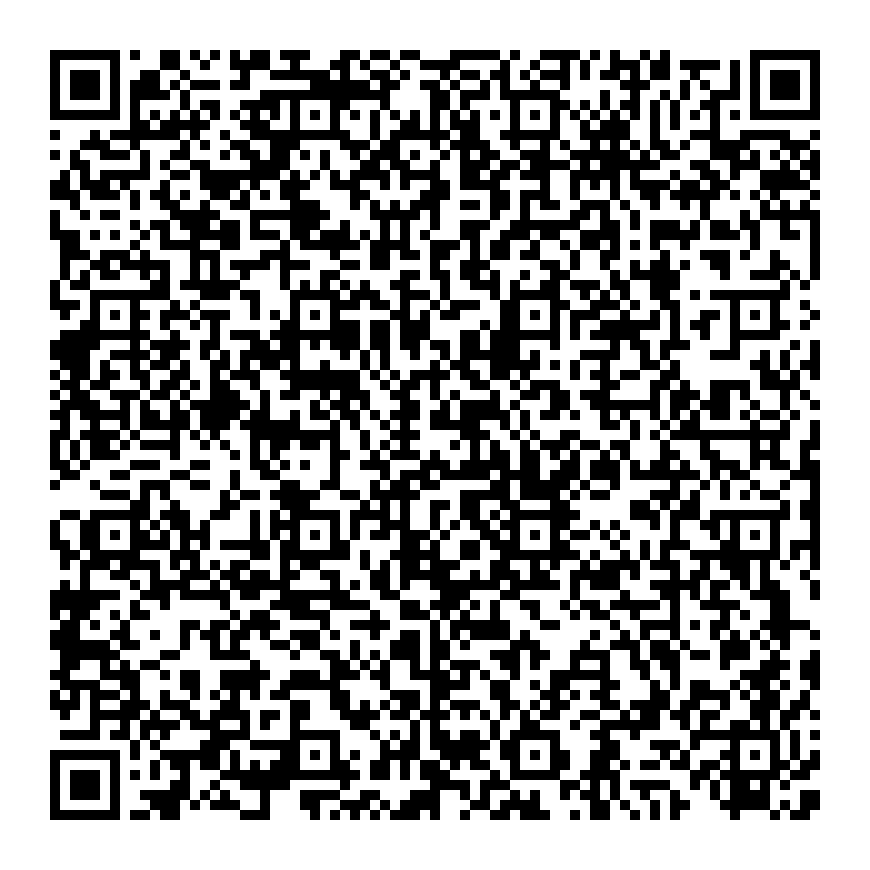

Connection message {'their_label': 'EAX', 'routing_state': 'none', 'their_did': 'XNA1Wnx1Rk1DAGMbE3p9oP', 'updated_at': '2020-09-21 19:14:22.735379Z', 'initiator': 'self', 'created_at': '2020-09-21 19:14:12.161741Z', 'accept': 'auto', 'connection_id': 'f8c030c9-d703-46a2-8543-e19f0440b763', 'state': 'request', 'invitation_mode': 'once', 'invitation_key': '42zjsardLXpkpNojcFkKHTznZ2HVqGnvMkYSUvWKPjgk'} f8c030c9-d703-46a2-8543-e19f0440b763
Connection message {'their_label': 'EAX', 'routing_state': 'none', 'their_did': 'XNA1Wnx1Rk1DAGMbE3p9oP', 'updated_at': '2020-09-21 19:14:22.763113Z', 'initiator': 'self', 'created_at': '2020-09-21 19:14:12.161741Z', 'accept': 'auto', 'my_did': 'GFWfybSewyRQRaKDzg6ABz', 'connection_id': 'f8c030c9-d703-46a2-8543-e19f0440b763', 'state': 'response', 'invitation_mode': 'once', 'invitation_key': '42zjsardLXpkpNojcFkKHTznZ2HVqGnvMkYSUvWKPjgk'} f8c030c9-d703-46a2-8543-e19f0440b763


In [6]:
import qrcode
# Link for connection invitation
input_data = inviteURL
# Creating an instance of qrcode
qr = qrcode.QRCode(
        version=1,
        box_size=10,
        border=5)
qr.add_data(input_data)
qr.make(fit=True)
img = qr.make_image(fill='black', back_color='white')
img.save('medical-school-agent_invite_QRcode.png')

from IPython.display import Image
Image(width=400, filename='./medical-school-agent_invite_QRcode.png')

## 5d. Check if established connection is in active state

In [7]:
import time

# print('Current state for ConnectionId {} is {}'.format(connection_id,STATE))
print(colored("Current state for ConnectionId {} is {}".format(connection_id,STATE), "magenta", attrs=["bold"]))
while STATE != 'active':
#     print('ConnectionId {0} is not in active state yet'.format(connection_id))
    print(colored("ConnectionId {0} is not in active state yet".format(connection_id), "yellow", attrs=["bold"]))
    trust_ping = await agent_controller.messaging.trust_ping(connection_id,'hello!')
#     print('Trust ping send to ConnectionId {0} to activate connection'.format(trust_ping))
    print(colored("Trust ping send to ConnectionId {0} to activate connection".format(trust_ping), "blue", attrs=["bold"]))
    time.sleep(5)
    
# print('ConnectionId: {0} is now active. Continue with notebook'.format(connection_id))
print(colored("ConnectionId: {0} is now active. Continue with notebook".format(connection_id), "green", attrs=["bold"]))


Current state for ConnectionId f8c030c9-d703-46a2-8543-e19f0440b763 is response
ConnectionId f8c030c9-d703-46a2-8543-e19f0440b763 is not in active state yet
Trust ping send to ConnectionId {'thread_id': 'b27c380c-987a-4e11-9948-36e697d059ca'} to activate connection
ConnectionId f8c030c9-d703-46a2-8543-e19f0440b763 is not in active state yet
Connection message {'their_label': 'EAX', 'routing_state': 'none', 'their_did': 'XNA1Wnx1Rk1DAGMbE3p9oP', 'updated_at': '2020-09-21 19:14:30.258578Z', 'initiator': 'self', 'created_at': '2020-09-21 19:14:12.161741Z', 'accept': 'auto', 'my_did': 'GFWfybSewyRQRaKDzg6ABz', 'connection_id': 'f8c030c9-d703-46a2-8543-e19f0440b763', 'state': 'active', 'invitation_mode': 'once', 'invitation_key': '42zjsardLXpkpNojcFkKHTznZ2HVqGnvMkYSUvWKPjgk'} f8c030c9-d703-46a2-8543-e19f0440b763
Connection f8c030c9-d703-46a2-8543-e19f0440b763 changed state to active
Trust ping send to ConnectionId {'thread_id': '4dbb6fc5-5bfd-46e6-b42c-30f4b1c0bc40'} to activate connection

## 6. Populate the Medical Qualification to Issue to Doctor

This would typically be done through a face to face identity check.

The notebook will ask you to input all the relevant fields.

In [8]:
qualification=input("Please enter your qualification: ")
institution=input("Please enter qualification institution: ")
surname=input("Please enter your surname: ")
name=input("Please enter your name: ")
issue_date=input("Please enter the qualification issue date: ")

credential_attributes = [
    {"name": "MDQ Primary Medical Qual", "value": qualification},
    {"name": "MDQ Issuing Institution", "value": institution},
    {"name": "MDQ Surname", "value": surname},
    {"name": "MDQ Given Names", "value": name},
    {"name": "MDQ Issue Date", "value": issue_date}
]
print(credential_attributes)

Please enter your qualification: MSc Comp Sci
Please enter qualification institution: Warwick
Please enter your surname: Jones
Please enter your name: Bob
Please enter the qualification issue date: 2020-08-01
[{'name': 'MDQ Primary Medical Qual', 'value': 'MSc Comp Sci'}, {'name': 'MDQ Issuing Institution', 'value': 'Warwick'}, {'name': 'MDQ Surname', 'value': 'Jones'}, {'name': 'MDQ Given Names', 'value': 'Bob'}, {'name': 'MDQ Issue Date', 'value': '2020-08-01'}]


## 7. Send Credential

This sends a credential to the doctor's mobile wallet you just connected with.

In [9]:
record = await agent_controller.issuer.send_credential(connection_id, schema_id, cred_def_id, credential_attributes, trace=False)
record_id = record['credential_exchange_id']
state = record['state']
role = record['role']
print(f"Credential exchange {record_id}, role: {role}, state: {state}")


Credential exchange e09596cc-ede4-4da4-856d-1d53fa2d3179, role: issuer, state: offer_sent
Handle Credentials
Credential exchange e09596cc-ede4-4da4-856d-1d53fa2d3179, role: issuer, state: offer_sent
Offering: [{'name': 'MDQ Primary Medical Qual', 'value': 'MSc Comp Sci'}, {'name': 'MDQ Issuing Institution', 'value': 'Warwick'}, {'name': 'MDQ Surname', 'value': 'Jones'}, {'name': 'MDQ Given Names', 'value': 'Bob'}, {'name': 'MDQ Issue Date', 'value': '2020-08-01'}]
Handle Credentials
Credential exchange e09596cc-ede4-4da4-856d-1d53fa2d3179, role: issuer, state: request_received
Offering: [{'name': 'MDQ Primary Medical Qual', 'value': 'MSc Comp Sci'}, {'name': 'MDQ Issuing Institution', 'value': 'Warwick'}, {'name': 'MDQ Surname', 'value': 'Jones'}, {'name': 'MDQ Given Names', 'value': 'Bob'}, {'name': 'MDQ Issue Date', 'value': '2020-08-01'}]
Handle Credentials
Credential exchange e09596cc-ede4-4da4-856d-1d53fa2d3179, role: issuer, state: credential_issued
Offering: [{'name': 'MDQ Prima

## 8. Accept credential in Mobile SSI Wallet

## 9. End of Tutorial

Be sure to terminate the controller so you can run another tutorial.

In [10]:
response = await agent_controller.terminate()
print(response)

None


# Proceed to Interact with the [General Medical Council](http://127.0.0.1:8890) to receive your Doctor's Licence.

You can get the token for this notebook by running `docker logs  interopen-hack_gmc-notebook_1`